# Historical Validation

Using CERF allocation, people affected and testing out Scenarios 2 and 3.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [81]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import LineString, Point, MultiLineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from src.datasources import codab, rsmc
from src import constants

In [3]:
df_rsmc = rsmc.load_historical_forecast_distances()
distance_cols = [x for x in df_rsmc.columns if "_distance_km" in x]
df_rsmc["any_distance_km"] = df_rsmc[distance_cols].min(axis=1)

In [4]:
cerf_emdat_df = pd.read_csv(
    Path(constants.AA_DATA_DIR)
    / "public/exploration/mdg/cerf_emdat_bngrc_data.csv"
)

In [5]:
cerf_emdat_df[cerf_emdat_df["Nom"] == "BATSIRAI"]

,Nom,Total Affected - EMDAT,Sinistres,CERF Allocations
56,BATSIRAI,112115.0,166671.0,4476918.0


In [6]:
adm0_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

In [7]:
# Create buffer around gdf_adm0 with the given distance
# Reproject to a CRS that uses meters (e.g., EPSG:3857)
gdf_adm0_buffer = gdf_adm0.to_crs(epsg=constants.mdg_epsg)

# Apply the buffer of 100 km (100,000 meters)
gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
    100 * 1000
)  # 100 km = 100,000 meters

# Reproject back to the original CRS
gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)

In [39]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    Path(constants.AA_DATA_DIR)
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [40]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks.loc[:, "Season"] = cyclone_tracks.apply(
    lambda x: (
        f"{x['Year'] - 1}-{x['Year']}"
        if x["Month"] <= 6
        else f"{x['Year']}-{x['Year'] + 1}"
    ),
    axis=1,
)

In [8]:
df_rsmc[df_rsmc["max_wind_kt"] >= 48]["name"].unique()

array(['0120102011', 'ALENGA', 'ANAIS', 'ADJALI', 'ANNABELLE', 'AVA',
       'ALICIA', 'ANA', 'ALVARO', 'ABELE', 'AMARA', 'BRANSBY', 'IRVING',
       'ALCIDE', 'BELNA', 'BATSIRAI', 'BELAL', 'BOLDWIN', 'BRUCE',
       'CORENTIN', 'BERGUITTA', 'BOUCHRA', 'AMBALI', 'BONGOYO', 'CANDICE',
       'BENILDE', 'CLAUDIA', 'BEJISA', 'KATE', 'CARLOS', 'KENANGA',
       'CALVINIA', 'CHALANE', 'DUMAKO', 'DARIAN', 'ANGGREK', 'BINGIZA',
       'CHANDA', 'DUMILE', 'BANSI', 'URIAH', 'DINEO', 'CEBILE', 'CILIDA',
       '0520202021', 'EMNATI', 'CHENESO', '0520232024', 'EMANG', 'COLIN',
       'CHEDZA', 'EMERAUDE', 'ENAWO', 'DUMAZILE', 'DIANE', 'DANILO',
       'FEZILE', 'DINGANI', 'DJOUNGOU', 'CHERONO', 'ETHEL', 'FELLENG',
       'DIAMONDRA', 'ELIAKIM', 'ELOISE', 'VERNON', 'FREDDY', 'ELEANOR',
       '0820102011', 'FUNSO', 'GINO', 'EUNICE', 'FANTALA', 'FAKIR',
       'FUNANI', 'ENALA', 'FILIPO', '0920102011', 'GIOVANNA', 'HARUNA',
       'FUNDI', 'FLAMBOYAN', 'GELENA', 'GABEKILE', 'GOMBE', 'GAMANE',
     

which storms are met for Scenario 2 and 3

In [9]:
# storms forecasted to be within 100 km of MDG
storms_within_aoi = df_rsmc[df_rsmc["any_distance_km"] <= 100]["name"].unique()
storms_onland = df_rsmc[df_rsmc["any_distance_km"] == 0]["name"].unique()

In [10]:
# Scenario 2
# Readiness
scenario2_storms_readiness = df_rsmc[
    (df_rsmc["name"].isin(storms_within_aoi))
    & (df_rsmc["MG_distance_km"] <= 100)
    & (df_rsmc["max_wind_kt"] >= 64)
    & (df_rsmc["lt_hour"].between(72, 120))
]["name"].unique()
scenario2_storms_action = df_rsmc[
    (df_rsmc["name"].isin(storms_within_aoi))
    & (df_rsmc["MG_distance_km"] <= 100)
    & (df_rsmc["max_wind_kt"] >= 64)
    & (df_rsmc["lt_hour"].between(0, 72))
]["name"].unique()

In [11]:
# Scenario 3
# Readiness
scenario3_storms_readiness = df_rsmc[
    (df_rsmc["name"].isin(storms_within_aoi))
    & (df_rsmc["MG_distance_km"] <= 100)
    & (df_rsmc["max_wind_kt"] >= 90)
    & (df_rsmc["lt_hour"].between(72, 120))
]["name"].unique()
scenario3_storms_action = df_rsmc[
    (df_rsmc["name"].isin(storms_within_aoi))
    & (df_rsmc["MG_distance_km"] <= 100)
    & (df_rsmc["max_wind_kt"] >= 90)
    & (df_rsmc["lt_hour"].between(0, 72))
]["name"].unique()

In [12]:
# Scenario 2.5
scenario2_point_5_storms_readiness = df_rsmc[
    (
        (df_rsmc["name"].isin(storms_within_aoi))
        & (df_rsmc["MG_distance_km"] <= 100)
        & (df_rsmc["max_wind_kt"] >= 90)
        & (df_rsmc["lt_hour"].between(72, 120))
    )
    | (
        (df_rsmc["name"].isin(storms_onland))
        & (df_rsmc["MG_distance_km"] == 0)
        & (df_rsmc["max_wind_kt"] >= 64)
        & (df_rsmc["lt_hour"].between(72, 120))
    )
]["name"].unique()
scenario2_point_5_storms_action = df_rsmc[
    (
        (df_rsmc["name"].isin(storms_within_aoi))
        & (df_rsmc["MG_distance_km"] <= 100)
        & (df_rsmc["max_wind_kt"] >= 90)
        & (df_rsmc["lt_hour"].between(0, 72))
    )
    | (
        (df_rsmc["name"].isin(storms_onland))
        & (df_rsmc["MG_distance_km"] == 0)
        & (df_rsmc["max_wind_kt"] >= 64)
        & (df_rsmc["lt_hour"].between(0, 72))
    )
]["name"].unique()

In [13]:
cerf_emdat_df.columns

Index(['Nom', 'Total Affected - EMDAT', 'Sinistres', 'CERF Allocations'], dtype='object')

In [14]:
df_rsmc.columns

Index(['valid_time', 'lt_hour', 'latitude', 'longitude', 'max_wind_kt',
       'season', 'name', 'numberseason', 'issue_time', 'MG_distance_km',
       'any_distance_km'],
      dtype='object')

In [15]:
# adding year and season to output
cerf_emdat_df = cerf_emdat_df.merge(
    df_rsmc[["name", "season"]].drop_duplicates(),
    left_on="Nom",
    right_on="name",
    how="left",
)

In [16]:
cerf_emdat_df = cerf_emdat_df[cerf_emdat_df["name"].isin(storms_within_aoi)]

In [17]:
cerf_emdat_df["Scenario 2 - Readiness"] = [
    storm in scenario2_storms_readiness for storm in cerf_emdat_df["name"]
]
cerf_emdat_df["Scenario 2 - Action"] = [
    storm in scenario2_storms_action for storm in cerf_emdat_df["name"]
]
cerf_emdat_df["Scenario 2.5 - Readiness"] = [
    storm in scenario2_point_5_storms_readiness
    for storm in cerf_emdat_df["name"]
]
cerf_emdat_df["Scenario 2.5 - Action"] = [
    storm in scenario2_point_5_storms_action for storm in cerf_emdat_df["name"]
]
cerf_emdat_df["Scenario 3 - Readiness"] = [
    storm in scenario3_storms_readiness for storm in cerf_emdat_df["name"]
]
cerf_emdat_df["Scenario 3 - Action"] = [
    storm in scenario3_storms_action for storm in cerf_emdat_df["name"]
]
cerf_emdat_df["season"] = (
    cerf_emdat_df["season"].str[:4] + "-" + cerf_emdat_df["season"].str[4:]
)
df = cerf_emdat_df[
    [
        "name",
        "season",
        "Scenario 2 - Readiness",
        "Scenario 2 - Action",
        # "Scenario 2.5 - Readiness",
        # "Scenario 2.5 - Action",
        "Scenario 3 - Readiness",
        "Scenario 3 - Action",
        "Total Affected - EMDAT",
        "Sinistres",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected - EMDAT", ascending=False)


# Define functions for highlighting and coloring bars
def highlight_true(val):
    color = "red" if val else ""
    return f"background-color: {color}"


def color_bar_affected(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, orange {val/df_sorted["Total Affected - EMDAT"].max()*100}%, transparent {val/df_sorted["Total Affected - EMDAT"].max()*100}%);'
    return ""


def color_bar_sinistres(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, #FFD700 {val/df_sorted["Sinistres"].max()*100}%, transparent {val/df_sorted["Sinistres"].max()*100}%);'
    return ""


def color_bar_cerf(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, green {val/df_sorted["CERF Allocations"].max()*100}%, transparent {val/df_sorted["CERF Allocations"].max()*100}%);'
    return ""


# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Scenario 2 - Readiness",
            "Scenario 2 - Action",
            # "Scenario 2.5 - Readiness",
            # "Scenario 2.5 - Action",
            "Scenario 3 - Readiness",
            "Scenario 3 - Action",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected - EMDAT"])
    .map(color_bar_sinistres, subset=["Sinistres"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "season": lambda x: (x if pd.notna(x) else ""),
            "Total Affected - EMDAT": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "Sinistres": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,name,season,Scenario 2 - Readiness,Scenario 2 - Action,Scenario 3 - Readiness,Scenario 3 - Action,Total Affected - EMDAT,Sinistres,CERF Allocations
46,ENAWO,2016-2017,True,True,True,True,"434,253","437,443","4,999,601"
63,FREDDY,2022-2023,True,True,True,True,"299,000","189,352","7,033,283"
38,GIOVANNA,2011-2012,True,True,True,True,"250,284","247,014","1,999,893"
44,CHEDZA,2014-2015,False,False,False,False,"174,007",,
58,EMNATI,2021-2022,True,True,True,True,"169,000","172,178","1,470,268"
47,AVA,2017-2018,False,True,False,False,"161,318","161,328",
59,ANA,2021-2022,False,False,False,False,"131,555",,
34,BINGIZA,2010-2011,True,True,False,True,"115,215","267,099",
56,BATSIRAI,2021-2022,True,True,True,True,"112,115","166,671","4,476,918"
62,CHENESO,2022-2023,False,False,False,False,"90,870","90,519",


In [18]:
scenario3_storms_best_track = pd.read_csv(
    Path(
        constants.AA_DATA_DIR,
        "public",
        "exploration",
        "mdg",
        "scenario3_storms_mfr_best_track.csv",
    ),
    header=None,
)[0].tolist()
cerf_emdat_df["Scenario 3 - Best Track"] = cerf_emdat_df["name"].isin(
    scenario3_storms_best_track
)

In [19]:
df = cerf_emdat_df[
    [
        "name",
        "season",
        # "Scenario 2 - Readiness",
        # "Scenario 2 - Action",
        # "Scenario 2.5 - Readiness",
        # "Scenario 2.5 - Action",
        "Scenario 3 - Readiness",
        "Scenario 3 - Action",
        "Scenario 3 - Best Track",
        "Total Affected - EMDAT",
        "Sinistres",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected - EMDAT", ascending=False)


# Define functions for highlighting and coloring bars
def highlight_true(val):
    color = "red" if val else ""
    return f"background-color: {color}"


def color_bar_affected(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, orange {val/df_sorted["Total Affected - EMDAT"].max()*100}%, transparent {val/df_sorted["Total Affected - EMDAT"].max()*100}%);'
    return ""


def color_bar_sinistres(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, #FFD700 {val/df_sorted["Sinistres"].max()*100}%, transparent {val/df_sorted["Sinistres"].max()*100}%);'
    return ""


def color_bar_cerf(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, green {val/df_sorted["CERF Allocations"].max()*100}%, transparent {val/df_sorted["CERF Allocations"].max()*100}%);'
    return ""


# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            # "Scenario 2 - Readiness",
            # "Scenario 2 - Action",
            # "Scenario 2.5 - Readiness",
            # "Scenario 2.5 - Action",
            "Scenario 3 - Readiness",
            "Scenario 3 - Action",
            "Scenario 3 - Best Track",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected - EMDAT"])
    .map(color_bar_sinistres, subset=["Sinistres"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "season": lambda x: (x if pd.notna(x) else ""),
            "Total Affected - EMDAT": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "Sinistres": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,name,season,Scenario 3 - Readiness,Scenario 3 - Action,Scenario 3 - Best Track,Total Affected - EMDAT,Sinistres,CERF Allocations
46,ENAWO,2016-2017,True,True,True,"434,253","437,443","4,999,601"
63,FREDDY,2022-2023,True,True,False,"299,000","189,352","7,033,283"
38,GIOVANNA,2011-2012,True,True,False,"250,284","247,014","1,999,893"
44,CHEDZA,2014-2015,False,False,False,"174,007",,
58,EMNATI,2021-2022,True,True,False,"169,000","172,178","1,470,268"
47,AVA,2017-2018,False,False,False,"161,318","161,328",
59,ANA,2021-2022,False,False,False,"131,555",,
34,BINGIZA,2010-2011,False,True,False,"115,215","267,099",
56,BATSIRAI,2021-2022,True,True,True,"112,115","166,671","4,476,918"
62,CHENESO,2022-2023,False,False,False,"90,870","90,519",


In [20]:
# return period by trigger
yr_len = df_rsmc["season"].nunique()
df_readiness_true = (
    df[df["Scenario 3 - Readiness"]].groupby("name")["season"].nunique().sum()
)
print(
    f"The readiness trigger is met every {round(yr_len / df_readiness_true, 1)} years."
)

The readiness trigger is met every 2.0 years.


In [21]:
# return period by trigger
yr_len = 2024 - 2010 + 1
df_action_true = (
    df[df["Scenario 3 - Action"]].groupby("name")["season"].nunique().sum()
)
print(
    f"The action trigger is met every {round(yr_len / df_action_true, 1)} years."
)

The action trigger is met every 1.5 years.


In [22]:
# Convert valid_time to datetime
df_rsmc["valid_time"] = pd.to_datetime(df_rsmc["valid_time"])

# Find the closest pass to land for each storm
landfall_df = df_rsmc.loc[
    df_rsmc.groupby("name")["any_distance_km"].idxmin(),
    ["name", "valid_time"],
]
landfall_times = landfall_df.rename(columns={"valid_time": "landfall_time"})
df_landfall = df_rsmc.merge(landfall_times, on="name", how="left")
df_landfall["time_to_landfall"] = (
    df_landfall["landfall_time"] - df_landfall["issue_time"]
).dt.total_seconds() / 3600  # in hours

df_landfall

,valid_time,lt_hour,latitude,longitude,max_wind_kt,season,name,numberseason,issue_time,MG_distance_km,any_distance_km,landfall_time,time_to_landfall
0,2010-10-25 12:00:00+00:00,0.0,-10.000000,86.200000,25.00,20102011,0120102011,0120102011,2010-10-25 12:00:00+00:00,4348.956262,4348.956262,2010-11-01 06:00:00+00:00,162.0
1,2010-10-25 12:30:00+00:00,0.5,-10.018333,86.193333,25.00,20102011,0120102011,0120102011,2010-10-25 12:00:00+00:00,4347.470541,4347.470541,2010-11-01 06:00:00+00:00,162.0
2,2010-10-25 13:00:00+00:00,1.0,-10.036667,86.186667,25.00,20102011,0120102011,0120102011,2010-10-25 12:00:00+00:00,4345.985857,4345.985857,2010-11-01 06:00:00+00:00,162.0
3,2010-10-25 13:30:00+00:00,1.5,-10.055000,86.180000,25.00,20102011,0120102011,0120102011,2010-10-25 12:00:00+00:00,4344.502208,4344.502208,2010-11-01 06:00:00+00:00,162.0
4,2010-10-25 14:00:00+00:00,2.0,-10.073333,86.173333,25.00,20102011,0120102011,0120102011,2010-10-25 12:00:00+00:00,4343.019597,4343.019597,2010-11-01 06:00:00+00:00,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
677530,2021-04-24 22:00:00+00:00,10.0,-6.620000,38.666667,21.00,20202021,JOBO,1620202021,2021-04-24 12:00:00+00:00,1233.956811,1233.956811,2021-04-20 21:00:00+00:00,-87.0
677531,2021-04-24 22:30:00+00:00,10.5,-6.592500,38.605000,20.75,20202021,JOBO,1620202021,2021-04-24 12:00:00+00:00,1240.090135,1240.090135,2021-04-20 21:00:00+00:00,-87.0
677532,2021-04-24 23:00:00+00:00,11.0,-6.565000,38.543333,20.50,20202021,JOBO,1620202021,2021-04-24 12:00:00+00:00,1246.236960,1246.236960,2021-04-20 21:00:00+00:00,-87.0
677533,2021-04-24 23:30:00+00:00,11.5,-6.537500,38.481667,20.25,20202021,JOBO,1620202021,2021-04-24 12:00:00+00:00,1252.399301,1252.399301,2021-04-20 21:00:00+00:00,-87.0


In [23]:
df_rsmc[
    (df_rsmc["MG_distance_km"] <= 100)
    & (df_rsmc["max_wind_kt"] >= 90)
    & (df_rsmc["lt_hour"].between(0, 72))
]["name"].unique()

array(['BELNA', 'BATSIRAI', 'BINGIZA', 'EMNATI', 'ENAWO', 'FREDDY',
       'GIOVANNA', 'HARUNA', 'GAMANE', 'HELLEN'], dtype=object)

In [25]:
# Find the first time readiness is reached (max_wind >= 90)
readiness_df = df_landfall[
    (df_landfall["name"].isin(storms_within_aoi))
    & (df_landfall["MG_distance_km"] <= 100)
    & (df_landfall["max_wind_kt"] >= 90)
    & (df_landfall["lt_hour"].between(72, 120))
]
readiness_df = readiness_df.groupby("name").first().reset_index()
readiness_df

,name,valid_time,lt_hour,latitude,longitude,max_wind_kt,season,numberseason,issue_time,MG_distance_km,any_distance_km,landfall_time,time_to_landfall
0,BATSIRAI,2022-02-05 12:00:00+00:00,120.0,-19.500000,49.880000,100.000000,20212022,0220212022,2022-01-31 12:00:00+00:00,95.801579,95.801579,2022-02-05 17:00:00+00:00,125.0
1,BELNA,2019-12-10 06:00:00+00:00,108.0,-18.140000,43.650000,90.000000,20192020,0220192020,2019-12-05 18:00:00+00:00,39.143965,39.143965,2019-12-08 11:30:00+00:00,65.5
2,EMNATI,2022-02-22 08:00:00+00:00,116.0,-19.000000,50.096667,95.000000,20212022,0520212022,2022-02-17 12:00:00+00:00,99.516537,99.516537,2022-02-22 15:30:00+00:00,123.5
3,ENAWO,2017-03-07 13:00:00+00:00,103.0,-16.570833,50.934167,97.916667,20162017,0620162017,2017-03-03 06:00:00+00:00,98.819582,98.819582,2017-03-07 07:00:00+00:00,97.0
4,FREDDY,2023-02-21 19:00:00+00:00,115.0,-19.804167,49.774167,94.166667,20222023,0720222023,2023-02-17 00:00:00+00:00,96.361238,96.361238,2023-02-21 23:30:00+00:00,119.5
5,GAMANE,2024-03-28 18:00:00+00:00,72.0,-14.810000,51.180000,95.000000,20232024,0920232024,2024-03-25 18:00:00+00:00,88.774436,88.774436,2024-03-27 15:30:00+00:00,45.5
6,GIOVANNA,2012-02-13 22:00:00+00:00,112.0,-16.873333,50.880000,100.000000,20112012,0920112012,2012-02-09 06:00:00+00:00,93.496967,93.496967,2012-02-14 05:00:00+00:00,119.0


In [26]:
# Find the first time action is reached (max_wind >= 90)
action_df = df_landfall[
    (df_landfall["name"].isin(storms_within_aoi))
    & (df_landfall["MG_distance_km"] <= 100)
    & (df_landfall["max_wind_kt"] >= 90)
    & (df_landfall["lt_hour"].between(0, 72))
]
action_df = action_df.groupby("name").first().reset_index()
action_df

,name,valid_time,lt_hour,latitude,longitude,max_wind_kt,season,numberseason,issue_time,MG_distance_km,any_distance_km,landfall_time,time_to_landfall
0,BATSIRAI,2022-02-05 01:30:00+00:00,67.5,-19.927500,49.723750,100.000000,20212022,0220212022,2022-02-02 06:00:00+00:00,94.329406,94.329406,2022-02-05 17:00:00+00:00,83.0
1,BELNA,2019-12-09 04:30:00+00:00,64.5,-14.891250,45.641250,95.000000,20192020,0220192020,2019-12-06 12:00:00+00:00,97.319973,97.319973,2019-12-08 11:30:00+00:00,47.5
2,BINGIZA,2011-02-14 00:00:00+00:00,36.0,-16.500000,50.500000,90.000000,20102011,0520102011,2011-02-12 12:00:00+00:00,56.127340,56.127340,2011-02-14 08:00:00+00:00,44.0
3,EMNATI,2022-02-22 02:30:00+00:00,68.5,-19.144167,50.009167,95.000000,20212022,0520212022,2022-02-19 06:00:00+00:00,96.022564,96.022564,2022-02-22 15:30:00+00:00,81.5
4,ENAWO,2017-03-07 00:00:00+00:00,60.0,-14.780000,50.810000,90.000000,20162017,0620162017,2017-03-04 12:00:00+00:00,56.571421,56.571421,2017-03-07 07:00:00+00:00,67.0
5,FREDDY,2023-02-21 14:30:00+00:00,68.5,-20.216667,49.708750,105.000000,20222023,0720222023,2023-02-18 18:00:00+00:00,98.640062,98.640062,2023-02-21 23:30:00+00:00,77.5
6,GAMANE,2024-03-27 12:30:00+00:00,48.5,-13.308750,50.943750,90.416667,20232024,0920232024,2024-03-25 12:00:00+00:00,99.980869,99.980869,2024-03-27 15:30:00+00:00,51.5
7,GIOVANNA,2012-02-13 15:00:00+00:00,57.0,-18.265000,50.340000,96.250000,20112012,0920112012,2012-02-11 06:00:00+00:00,97.268791,97.268791,2012-02-14 05:00:00+00:00,71.0
8,HARUNA,2013-02-21 16:00:00+00:00,22.0,-22.668667,42.328667,90.000000,20122013,0920122013,2013-02-20 18:00:00+00:00,98.939963,98.939963,2013-02-21 22:30:00+00:00,28.5
9,HELLEN,2014-03-30 21:30:00+00:00,9.5,-15.119167,44.897917,111.041667,20132014,1420132014,2014-03-30 12:00:00+00:00,97.582113,97.582113,2014-03-31 16:00:00+00:00,28.0


In [27]:
# Merge the readiness and action DataFrames into a single table based on 'name'
df_combined = pd.merge(
    readiness_df[["name", "lt_hour", "any_distance_km"]],
    action_df[["name", "lt_hour", "any_distance_km"]],
    on="name",
    how="outer",
    suffixes=("_readiness", "_action"),
)

df_combined

,name,lt_hour_readiness,any_distance_km_readiness,lt_hour_action,any_distance_km_action
0,BATSIRAI,120.0,95.801579,67.5,94.329406
1,BELNA,108.0,39.143965,64.5,97.319973
2,BINGIZA,NaN,NaN,36.0,56.127340
3,EMNATI,116.0,99.516537,68.5,96.022564
4,ENAWO,103.0,98.819582,60.0,56.571421
5,FREDDY,115.0,96.361238,68.5,98.640062
6,GAMANE,72.0,88.774436,48.5,99.980869
7,GIOVANNA,112.0,93.496967,57.0,97.268791
8,HARUNA,NaN,NaN,22.0,98.939963
9,HELLEN,NaN,NaN,9.5,97.582113


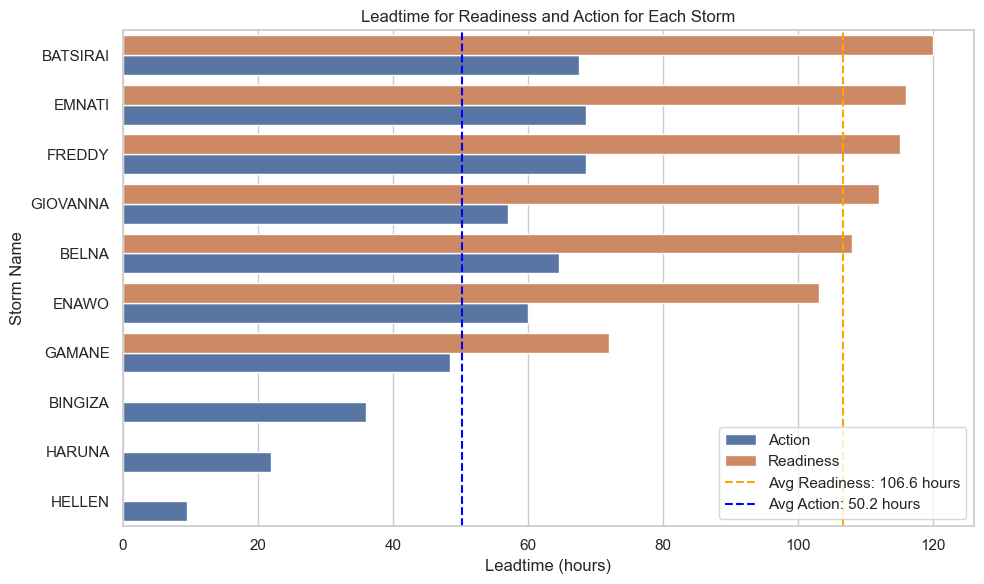

In [28]:
# Reshape the data into long format for grouped bars
df_melted = df_combined.melt(
    id_vars="name",
    value_vars=["lt_hour_readiness", "lt_hour_action"],
    var_name="trigger",
    value_name="time_to_trigger",
)

# Rename the 'trigger' column for clarity
df_melted["trigger"] = df_melted["trigger"].replace(
    {"lt_hour_readiness": "Readiness", "lt_hour_action": "Action"}
)

# Sort the dataframe by 'time_to_trigger' in ascending order to order storms
df_melted["name"] = pd.Categorical(
    df_melted["name"],
    categories=df_melted.groupby("name")["time_to_trigger"]
    .max()
    .sort_values(ascending=True)
    .index,
    ordered=True,
)

# Set plot style
sns.set(style="whitegrid")

# Create a grouped bar plot with storms on the y-axis
plt.figure(figsize=(10, 6))

# Set hue order so that Readiness is always on top of Action
sns.barplot(
    x="time_to_trigger",
    y="name",
    hue="trigger",
    data=df_melted,
    hue_order=["Action", "Readiness"],
)

# Add a vertical line for the average time to trigger for Readiness and Action
readiness_avg = df_melted[df_melted["trigger"] == "Readiness"][
    "time_to_trigger"
].mean()
action_avg = df_melted[df_melted["trigger"] == "Action"][
    "time_to_trigger"
].mean()

plt.axvline(
    x=readiness_avg,
    color="orange",
    linestyle="--",
    label=f"Avg Readiness: {readiness_avg:.1f} hours",
)
plt.axvline(
    x=action_avg,
    color="blue",
    linestyle="--",
    label=f"Avg Action: {action_avg:.1f} hours",
)

# Add labels and title
plt.xlabel("Leadtime (hours)")
plt.ylabel("Storm Name")
plt.title("Leadtime for Readiness and Action for Each Storm")

# Invert the y-axis to show storms in reverse order (optional)
plt.gca().invert_yaxis()

# Add a legend to show the average lines
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [29]:
df_rsmc[(df_rsmc["name"] == "GIOVANNA") & (df_rsmc["any_distance_km"] <= 100)]

,valid_time,lt_hour,latitude,longitude,max_wind_kt,season,name,numberseason,issue_time,MG_distance_km,any_distance_km
459903,2012-02-13 22:00:00+00:00,112.0,-16.873333,50.88000,100.000000,20112012,GIOVANNA,0920112012,2012-02-09 06:00:00+00:00,93.496967,93.496967
459904,2012-02-13 22:30:00+00:00,112.5,-16.876250,50.81125,100.000000,20112012,GIOVANNA,0920112012,2012-02-09 06:00:00+00:00,86.341177,86.341177
459905,2012-02-13 23:00:00+00:00,113.0,-16.879167,50.74250,100.000000,20112012,GIOVANNA,0920112012,2012-02-09 06:00:00+00:00,79.225375,79.225375
459906,2012-02-13 23:30:00+00:00,113.5,-16.882083,50.67375,100.000000,20112012,GIOVANNA,0920112012,2012-02-09 06:00:00+00:00,72.161093,72.161093
459907,2012-02-14 00:00:00+00:00,114.0,-16.885000,50.60500,100.000000,20112012,GIOVANNA,0920112012,2012-02-09 06:00:00+00:00,65.164765,65.164765
...,...,...,...,...,...,...,...,...,...,...,...
468493,2012-02-18 15:30:00+00:00,3.5,-26.395750,45.48750,58.541667,20112012,GIOVANNA,0920112012,2012-02-18 12:00:00+00:00,90.536391,90.536391
468494,2012-02-18 16:00:00+00:00,4.0,-26.388000,45.60000,58.333333,20112012,GIOVANNA,0920112012,2012-02-18 12:00:00+00:00,90.517180,90.517180
468495,2012-02-18 16:30:00+00:00,4.5,-26.380250,45.71250,58.125000,20112012,GIOVANNA,0920112012,2012-02-18 12:00:00+00:00,91.529698,91.529698
468496,2012-02-18 17:00:00+00:00,5.0,-26.372500,45.82500,57.916667,20112012,GIOVANNA,0920112012,2012-02-18 12:00:00+00:00,93.722875,93.722875


In [59]:
cyclone_tracks["time"] = pd.to_datetime(
    cyclone_tracks[["Year", "Month", "Day"]].astype(str).agg("-".join, axis=1)
    + " "
    + cyclone_tracks["UTC"].astype(str)
    + ":00:00",
    format="%Y-%m-%d %H:%M:%S",
)

Time to Readiness and Action Triggers

In [77]:
# Define the list of storms to plot
storm_names = [
    "batsirai",
    "emnati",
    "freddy",
    "giovanna",
    "belna",
    "enawo",
]

C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:85: SettingWithCopyWarning: 
A value is trying to be s

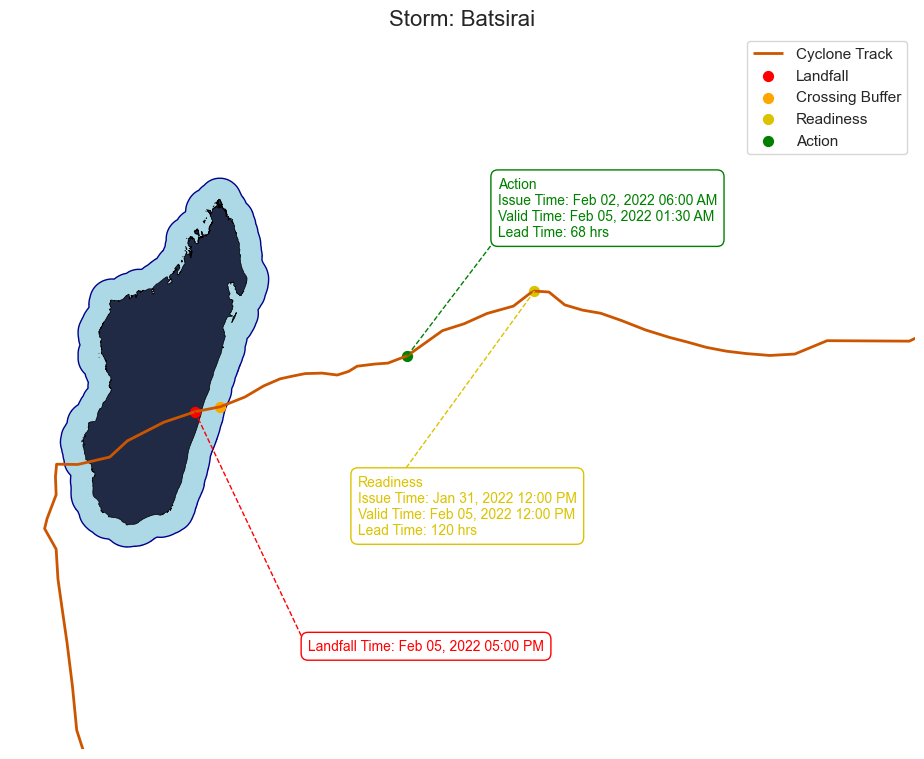

C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:85: SettingWithCopyWarning: 
A value is trying to be s

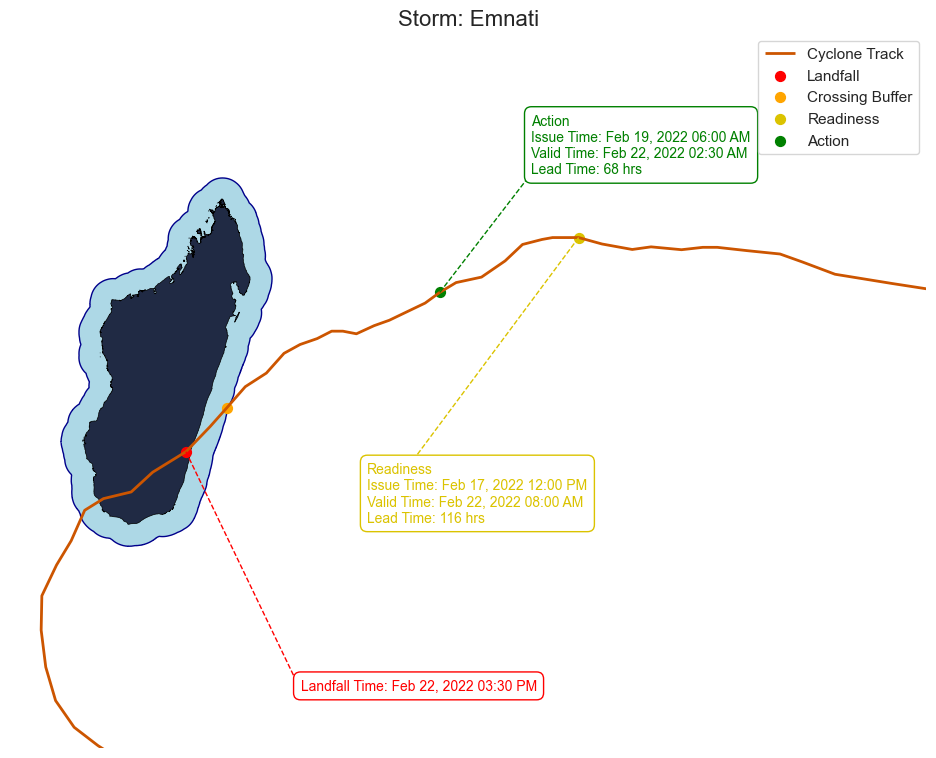

C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:85: SettingWithCopyWarning: 
A value is trying to be s

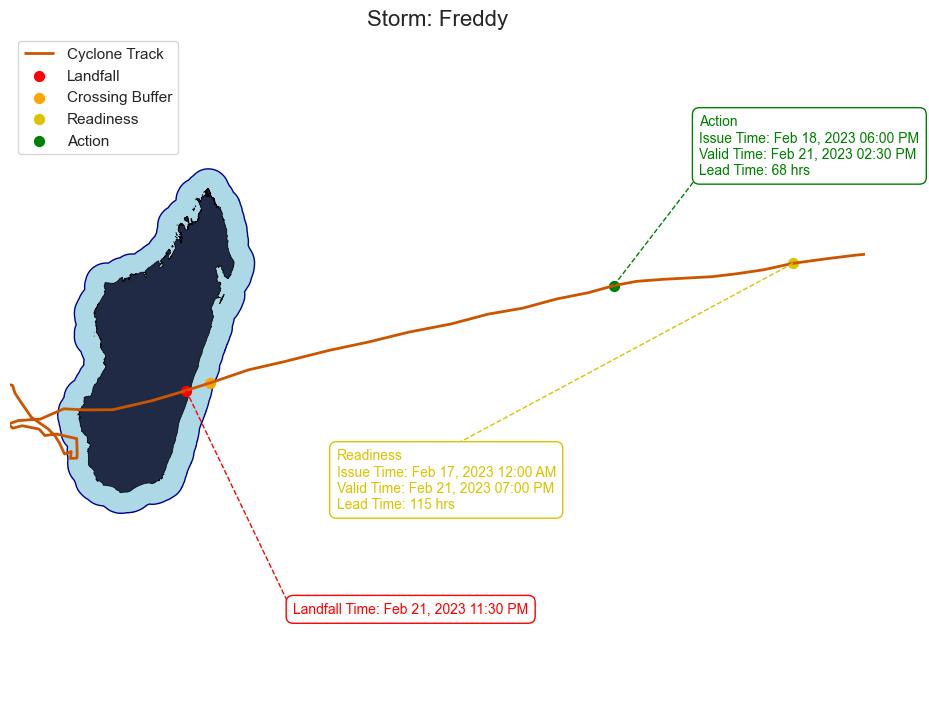

C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:85: SettingWithCopyWarning: 
A value is trying to be s

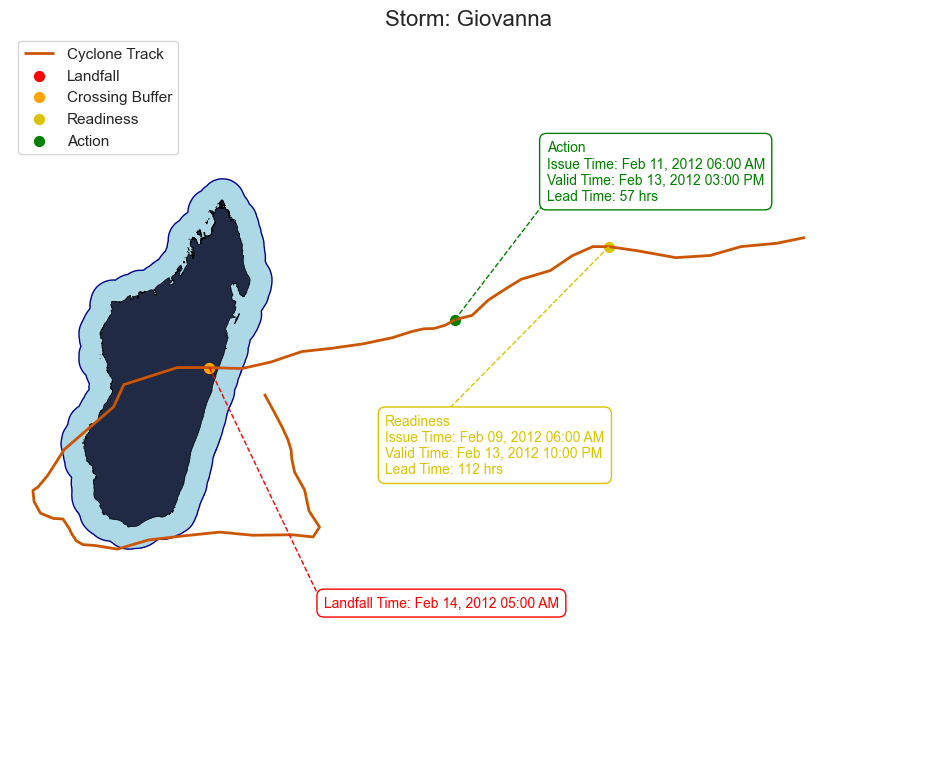

C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:85: SettingWithCopyWarning: 
A value is trying to be s

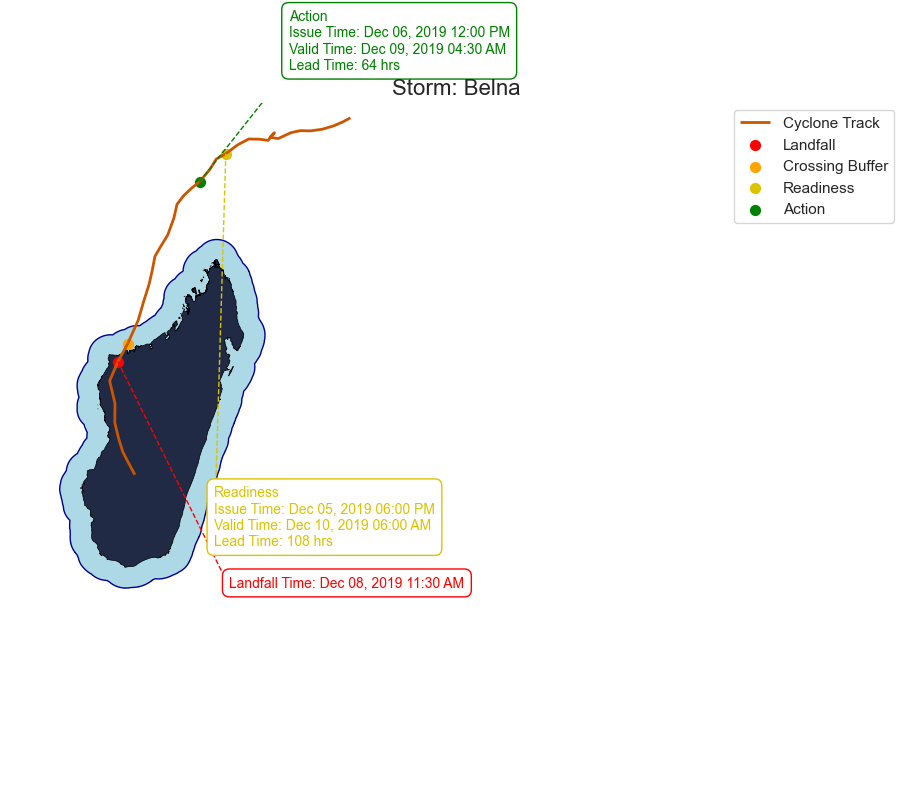

C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_adm0_buffer.geometry.unary_union
C:\Users\pauni\AppData\Local\Temp\ipykernel_18808\2171171088.py:85: SettingWithCopyWarning: 
A value is trying to be s

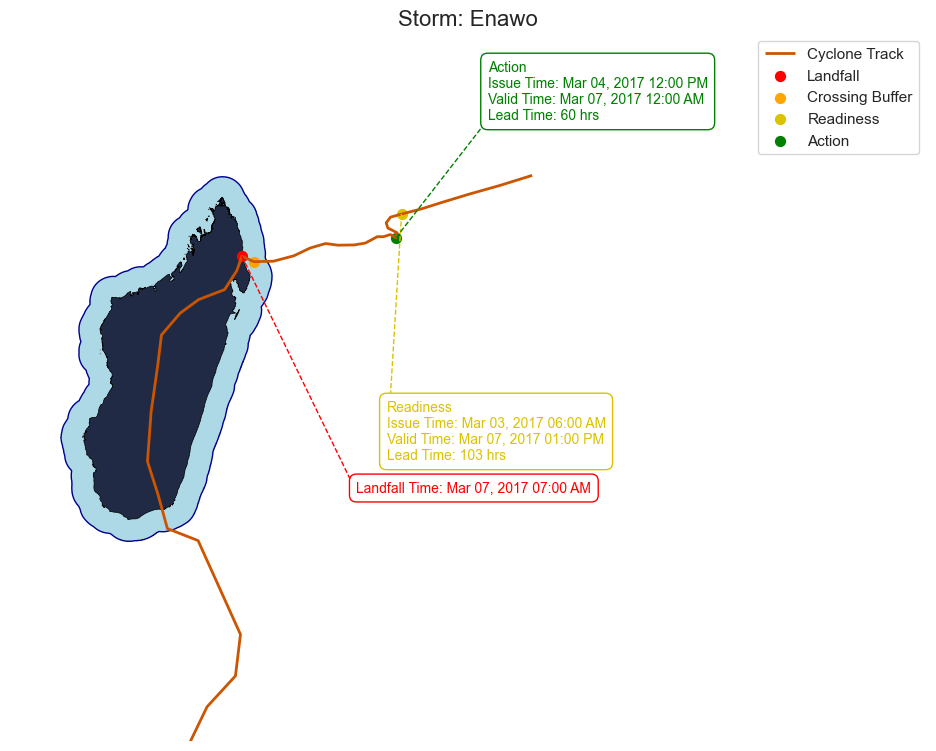

In [184]:
# Loop through each storm
for storm_name in storm_names:

    # Filter cyclone_tracks for the current storm
    storm_tracks = cyclone_tracks[
        cyclone_tracks["Name"].str.lower() == storm_name.lower()
    ]

    # Ensure there are tracks for the storm
    if storm_tracks.empty:
        print(f"No data for {storm_name} in cyclone tracks.")
        continue

    # Create GeoDataFrame for the storm's track
    gdf_tracks = gpd.GeoDataFrame(
        storm_tracks,
        geometry=gpd.points_from_xy(storm_tracks["Lon"], storm_tracks["Lat"]),
        crs="EPSG:4326",
    )

    # Filter out invalid geometries
    gdf_tracks = gdf_tracks[gdf_tracks.is_valid]

    # Create a LineString for the storm's track
    track_line = LineString(gdf_tracks.geometry)

    # Find the first point in cyclone tracks that intersects with gdf_adm0 (landfall)
    landfall_point = (
        gdf_tracks[
            gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
        ].iloc[0]
        if not gdf_tracks[
            gdf_tracks.geometry.intersects(gdf_adm0.geometry.unary_union)
        ].empty
        else None
    )

    # Find the first point in cyclone tracks that intersects with gdf_adm0_buffer (crossing buffer)
    crossing_buffer_point = (
        gdf_tracks[
            gdf_tracks.geometry.intersects(
                gdf_adm0_buffer.geometry.unary_union
            )
        ].iloc[0]
        if not gdf_tracks[
            gdf_tracks.geometry.intersects(
                gdf_adm0_buffer.geometry.unary_union
            )
        ].empty
        else None
    )

    # Ensure we found both points
    if landfall_point is None:
        print(f"No landfall point found for {storm_name}.")
        continue
    if crossing_buffer_point is None:
        print(f"No crossing buffer point found for {storm_name}.")
        continue

    # Filter readiness data for the storm
    readiness_storm_df = readiness_df[
        readiness_df["name"].str.lower() == storm_name.lower()
    ]

    # Ensure data exists for readiness
    if readiness_storm_df.empty:
        print(f"No readiness data found for {storm_name}.")
        continue

    # Extract landfall time from readiness_df for the current storm
    landfall_time = (
        readiness_storm_df["landfall_time"].iloc[0]
        if not readiness_storm_df.empty
        else "Unknown"
    )

    # Format landfall_time for better readability
    landfall_time_str = pd.to_datetime(landfall_time).strftime(
        "%b %d, %Y %I:%M %p"
    )

    # Find the closest readiness point to the issue_time
    def find_closest_readiness_point(df, issue_time):
        df["issue_time"] = pd.to_datetime(df["issue_time"]).dt.tz_localize(
            None
        )
        issue_time = pd.to_datetime(issue_time).tz_localize(None)
        df["time_diff"] = abs(
            (df["issue_time"] - issue_time).dt.total_seconds()
        )
        return df.loc[df["time_diff"].idxmin()]

    # For each storm, find the readiness point with the closest issue_time
    readiness_point = find_closest_readiness_point(
        readiness_storm_df, storm_tracks["time"].iloc[0]
    )

    # Find the closest track point in gdf_tracks to the readiness issue_time
    def find_closest_track_point(df, target_time):
        df["time_diff"] = abs(
            (
                pd.to_datetime(df["time"]) - pd.to_datetime(target_time)
            ).dt.total_seconds()
        )
        return df.loc[df["time_diff"].idxmin()]

    # Find the closest track point (Readiness point)
    closest_track_point = find_closest_track_point(
        gdf_tracks, readiness_point["issue_time"]
    )

    # Create GeoDataFrame for the closest track point
    gdf_closest_track = gpd.GeoDataFrame(
        [closest_track_point],
        geometry=[
            Point(closest_track_point["Lon"], closest_track_point["Lat"])
        ],
        crs="EPSG:4326",
    )

    # Create GeoDataFrames for the points
    gdf_landfall = gpd.GeoDataFrame(
        [landfall_point], geometry=[landfall_point.geometry], crs="EPSG:4326"
    )
    gdf_crossing_buffer = gpd.GeoDataFrame(
        [crossing_buffer_point],
        geometry=[crossing_buffer_point.geometry],
        crs="EPSG:4326",
    )
    # Filter action data for the storm
    action_storm_df = action_df[
        action_df["name"].str.lower() == storm_name.lower()
    ]

    # Ensure data exists for actions
    if action_storm_df.empty:
        print(f"No action data found for {storm_name}.")
        continue

    # Find the closest action point to the issue_time
    def find_closest_action_point(df, issue_time):
        df["issue_time"] = pd.to_datetime(df["issue_time"]).dt.tz_localize(
            None
        )
        issue_time = pd.to_datetime(issue_time).tz_localize(None)
        df["time_diff"] = abs(
            (df["issue_time"] - issue_time).dt.total_seconds()
        )
        return df.loc[df["time_diff"].idxmin()]

    # Find the closest action point to the issue_time and ensure it maps to the track
    action_point = find_closest_action_point(
        action_storm_df, storm_tracks["time"].iloc[0]
    )

    # Find the closest track point corresponding to the action point
    closest_action_track_point = find_closest_track_point(
        gdf_tracks, action_point["issue_time"]
    )

    # Create GeoDataFrame for the closest action track point
    gdf_action_point = gpd.GeoDataFrame(
        [closest_action_track_point],
        geometry=[
            Point(
                closest_action_track_point["Lon"],
                closest_action_track_point["Lat"],
            )
        ],
        crs="EPSG:4326",
    )
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot background admin areas (assuming adm and adm0 GeoDataFrames are available)
    gdf_adm0_buffer.plot(ax=ax, color="lightblue", edgecolor="darkblue")
    gdf_adm0.plot(ax=ax, color="#202A44", edgecolor="black", linewidth=0.5)

    # Plot the cyclone track (line)
    gpd.GeoSeries([track_line]).plot(
        ax=ax, color="#CC5500", linewidth=2, label="Cyclone Track"
    )

    # Plot points for landfall and crossing buffer
    gdf_landfall.plot(ax=ax, color="red", label="Landfall", markersize=50)
    gdf_crossing_buffer.plot(
        ax=ax, color="orange", label="Crossing Buffer", markersize=50
    )

    # Plot readiness point with issue_time and lead time
    gdf_closest_track.plot(
        ax=ax, color="#dbc300", label="Readiness", markersize=50
    )

    # Format the issue_time and time_to_landfall
    issue_time_str = pd.to_datetime(readiness_point["issue_time"]).strftime(
        "%b %d, %Y %I:%M %p"
    )
    readiness_valid_time_str = pd.to_datetime(
        readiness_point["valid_time"]
    ).strftime("%b %d, %Y %I:%M %p")
    lead_time = round(readiness_point["lt_hour"])

    # Set plot bounds and remove grid
    ax.grid(False)
    ax.set_xlim([40, 80])
    ax.set_ylim([-35, -5])

    # Add a text box with landfall time and draw a line from the text box to the landfall point
    if landfall_point is not None:
        # Coordinates for text box (adjust the x and y offsets for better placement)
        text_x = (
            landfall_point.geometry.x + 5
        )  # Slightly offset to the right of the point
        text_y = (
            landfall_point.geometry.y - 10
        )  # Slightly offset above the point

        # Add the text box with landfall time
        ax.text(
            text_x,
            text_y,
            f"Landfall Time: {landfall_time_str}",
            fontsize=10,
            color="red",
            ha="left",
            bbox=dict(
                facecolor="white", edgecolor="red", boxstyle="round,pad=0.5"
            ),
        )

        # Add a line connecting the text box to the landfall point
        ax.plot(
            [landfall_point.geometry.x, text_x],
            [landfall_point.geometry.y, text_y],
            color="red",
            lw=1,
            ls="--",
        )

    # Coordinates for the text box (offset slightly for better visibility)
    text_x = readiness_point["longitude"] + 5.5
    text_y = readiness_point["latitude"] - 6.5

    # Add text box with issue_time and lead time
    ax.text(
        text_x,
        text_y,
        f"Readiness\nIssue Time: {issue_time_str}\nValid Time: {readiness_valid_time_str}\nLead Time: {lead_time} hrs",
        fontsize=10,
        color="#dbc300",
        ha="left",
        bbox=dict(
            facecolor="white", edgecolor="#dbc300", boxstyle="round,pad=0.5"
        ),
    )

    # Add a line connecting the text box to the readiness point
    ax.plot(
        [
            gdf_closest_track.geometry.x.values[0],
            text_x,
        ],  # X-coordinates: dot to text
        [
            gdf_closest_track.geometry.y.values[0],
            text_y,
        ],  # Y-coordinates: dot to text
        color="#dbc300",
        lw=1,
        ls="--",
    )
    # Plot action point on the track
    gdf_action_point.plot(ax=ax, color="green", label="Action", markersize=50)

    # Format the action_time and calculate action lead time
    action_time_str = pd.to_datetime(action_point["issue_time"]).strftime(
        "%b %d, %Y %I:%M %p"
    )
    action_valid_time_str = pd.to_datetime(
        action_point["valid_time"]
    ).strftime("%b %d, %Y %I:%M %p")
    action_lead_time = round(action_point["lt_hour"])

    # Coordinates for the text box (offset slightly for better visibility)
    action_text_x = gdf_action_point.geometry.x.values[0] + 4
    action_text_y = gdf_action_point.geometry.y.values[0] + 5

    # Add text box with action_time and lead time
    ax.text(
        action_text_x,
        action_text_y,
        f"Action\nIssue Time: {action_time_str}\nValid Time: {action_valid_time_str}\nLead Time: {action_lead_time} hrs",
        fontsize=10,
        color="green",
        ha="left",
        bbox=dict(
            facecolor="white", edgecolor="green", boxstyle="round,pad=0.5"
        ),
    )

    # Add a line connecting the text box to the action point
    ax.plot(
        [
            gdf_action_point.geometry.x.values[0],
            action_text_x,
        ],  # X-coordinates: dot to text
        [
            gdf_action_point.geometry.y.values[0],
            action_text_y,
        ],  # Y-coordinates: dot to text
        color="green",
        lw=1,
        ls="--",
    )
    # Show the plot
    # Add title with storm's name
    ax.set_title(f"Storm: {storm_name.capitalize()}", fontsize=16)

    # Add legend
    ax.legend()
    plt.tight_layout()
    ax.set_axis_off()  # Remove axis lines

    plt.show()